# PM2.5 Forecast

## Objectives: 
Air quality in Thailand has recently been concerned, especially in many big cities such as Patumthani, Bangkok and Chiang Mai. As air pollution affects health, knowing how the air quality will be in advance can help people prepare to protect themselves. This project motivation is to forecast the quantity of a pollutant "PM2.5" (only Din Daeng district) in order to estimate how its level will be in the next two days.

## Dataset
The dataset used in the prediction was from http://air4thai.pcd.go.th/webV2/history/ which was derived by web-scraping. To calculate AQI, several factors are considered. According to AirNow, these factors include PM2.5, PM10, O3, CO, NO2 and SO2. The AQI index value is the maximum of AQI index of each pollutants at a time.

The dataset was the values of mentioned pollutants (except SO2) which were measured at Din Daeng station. This dataset spanned from 1 Dec 2021 to 5 Jan 2022 and were collected hourly. All the parameters from measurement are followings:
- **PM2.5 (ug/m^3)** - particles, in fact, particulate matter which have diamether of 2.5 micrometres or smaller.
- **PM10 (ug/m^3)** - particles which have diameter of 10 micrometres or smaller.
- **O3 (ppb)** - Ozone 
- **CO (ppm)** - Carbon monoxide
- **NO2 (ppb)** - Nitrogen dioxide


### Note:
According to AirNow, data for AQI calculation should be at least 3 digit. However, most of data that the source provided was rounded up. Some measurement stations are lack of data. For example, there are many stations that has only PM2.5 and PM10 values. 

## Import libraries

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima

pd.set_option("display.max_rows", None)

## Import Data

In [117]:
df = pd.read_csv('report_54t_dindaeng.csv')

## Exploratory Data Analysis

In [118]:
# To see the first five rows of dataframe
df.head()

,No,date,time,PM2.5,PM10,O3,CO,NO2
0,1,2021-12-01,00:00 - 01:00,32,79,18.0,1.28,32.0
1,2,2021-12-01,01:00 - 02:00,27,78,19.0,1.23,29.0
2,3,2021-12-01,02:00 - 03:00,25,74,21.0,1.22,25.0
3,4,2021-12-01,03:00 - 04:00,33,72,30.0,1.15,18.0
4,5,2021-12-01,04:00 - 05:00,40,66,19.0,1.23,26.0


In [119]:
# To see the last five rows of dataframe
df.tail()

,No,date,time,PM2.5,PM10,O3,CO,NO2
859,860,2022-01-05,19:00 - 20:00,55,92,12.0,2.14,93.0
860,861,2022-01-05,20:00 - 21:00,56,98,4.0,2.65,107.0
861,862,2022-01-05,21:00 - 22:00,63,104,4.0,2.11,87.0
862,863,2022-01-05,22:00 - 23:00,59,110,2.0,1.85,74.0
863,864,2022-01-05,23:00 - 24:00,52,109,2.0,1.51,66.0


In [120]:
# drop the first column
df = df.drop(['No'], axis=1)
df.head()

,date,time,PM2.5,PM10,O3,CO,NO2
0,2021-12-01,00:00 - 01:00,32,79,18.0,1.28,32.0
1,2021-12-01,01:00 - 02:00,27,78,19.0,1.23,29.0
2,2021-12-01,02:00 - 03:00,25,74,21.0,1.22,25.0
3,2021-12-01,03:00 - 04:00,33,72,30.0,1.15,18.0
4,2021-12-01,04:00 - 05:00,40,66,19.0,1.23,26.0


### Make Datetime as Datetime Index

In [121]:
df['time_'] = df['time'].str.split().str.get(0)
df.head()

,date,time,PM2.5,PM10,O3,CO,NO2,time_
0,2021-12-01,00:00 - 01:00,32,79,18.0,1.28,32.0,00:00
1,2021-12-01,01:00 - 02:00,27,78,19.0,1.23,29.0,01:00
2,2021-12-01,02:00 - 03:00,25,74,21.0,1.22,25.0,02:00
3,2021-12-01,03:00 - 04:00,33,72,30.0,1.15,18.0,03:00
4,2021-12-01,04:00 - 05:00,40,66,19.0,1.23,26.0,04:00


In [122]:
df['datetime'] = df['date'] + ' ' + df['time_'] + ':00'
df.head()

,date,time,PM2.5,PM10,O3,CO,NO2,time_,datetime
0,2021-12-01,00:00 - 01:00,32,79,18.0,1.28,32.0,00:00,2021-12-01 00:00:00
1,2021-12-01,01:00 - 02:00,27,78,19.0,1.23,29.0,01:00,2021-12-01 01:00:00
2,2021-12-01,02:00 - 03:00,25,74,21.0,1.22,25.0,02:00,2021-12-01 02:00:00
3,2021-12-01,03:00 - 04:00,33,72,30.0,1.15,18.0,03:00,2021-12-01 03:00:00
4,2021-12-01,04:00 - 05:00,40,66,19.0,1.23,26.0,04:00,2021-12-01 04:00:00


In [123]:
dd_pollutants = df[['datetime', 'PM2.5', 'PM10', 'O3', 'CO', 'NO2']]
dd_pollutants.head()

,datetime,PM2.5,PM10,O3,CO,NO2
0,2021-12-01 00:00:00,32,79,18.0,1.28,32.0
1,2021-12-01 01:00:00,27,78,19.0,1.23,29.0
2,2021-12-01 02:00:00,25,74,21.0,1.22,25.0
3,2021-12-01 03:00:00,33,72,30.0,1.15,18.0
4,2021-12-01 04:00:00,40,66,19.0,1.23,26.0


In [124]:
dd_pollutants['datetime'] = pd.to_datetime(dd_pollutants["datetime"])
dd_pollutants.set_index('datetime', inplace=True)
dd_pollutants.index.freq = 'H'

/tmp/ipykernel_8247/2845609501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_pollutants['datetime'] = pd.to_datetime(dd_pollutants["datetime"])


In [125]:
dd_pollutants.head()

,PM2.5,PM10,O3,CO,NO2
datetime,,,,,
2021-12-01 00:00:00,32,79,18.0,1.28,32.0
2021-12-01 01:00:00,27,78,19.0,1.23,29.0
2021-12-01 02:00:00,25,74,21.0,1.22,25.0
2021-12-01 03:00:00,33,72,30.0,1.15,18.0
2021-12-01 04:00:00,40,66,19.0,1.23,26.0


In [126]:
dd_pollutants.index

DatetimeIndex(['2021-12-01 00:00:00', '2021-12-01 01:00:00',
               '2021-12-01 02:00:00', '2021-12-01 03:00:00',
               '2021-12-01 04:00:00', '2021-12-01 05:00:00',
               '2021-12-01 06:00:00', '2021-12-01 07:00:00',
               '2021-12-01 08:00:00', '2021-12-01 09:00:00',
               ...
               '2022-01-05 14:00:00', '2022-01-05 15:00:00',
               '2022-01-05 16:00:00', '2022-01-05 17:00:00',
               '2022-01-05 18:00:00', '2022-01-05 19:00:00',
               '2022-01-05 20:00:00', '2022-01-05 21:00:00',
               '2022-01-05 22:00:00', '2022-01-05 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=864, freq='H')

In [127]:
dd_pollutants.describe()

,PM2.5,PM10,O3,CO,NO2
count,864.000000,864.000000,747.000000,807.000000,807.000000
mean,40.590278,83.712963,13.859438,1.447794,44.022305
std,15.166857,26.332723,10.259779,0.529848,15.947168
min,12.000000,30.000000,1.000000,0.380000,10.000000
25%,30.000000,65.000000,5.000000,1.050000,32.000000
50%,37.000000,81.000000,11.000000,1.380000,43.000000
75%,49.000000,101.000000,21.000000,1.760000,55.000000
max,101.000000,174.000000,51.000000,3.720000,107.000000


### Dealing with Missing Values
As the data was collected by hour, the missing values should not be much different from its forward values. Therefore, the null values in the dataframe were filled with 'ffill' method.

In [128]:
# check the number of missing values in each column
dd_pollutants.isna().sum()

PM2.5      0
PM10       0
O3       117
CO        57
NO2       57
dtype: int64

In [129]:
cleaned_pollutants = dd_pollutants.fillna(method='ffill')
cleaned_pollutants.isna().sum()

PM2.5    0
PM10     0
O3       0
CO       0
NO2      0
dtype: int64

Text(0.5, 1.0, 'Air pollutant levels')

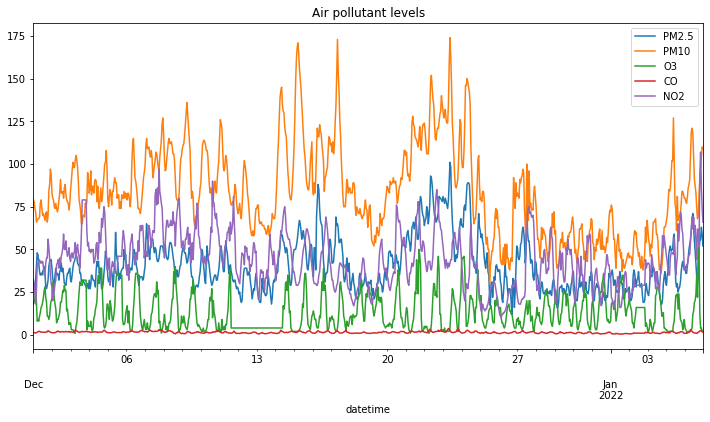

In [130]:
# plot all the data
cleaned_pollutants.plot(figsize=(12,6));
plt.title("Air pollutant levels")

In [131]:
cleaned_pollutants.describe()

,PM2.5,PM10,O3,CO,NO2
count,864.000000,864.000000,864.00000,864.000000,864.000000
mean,40.590278,83.712963,13.33912,1.444132,44.009259
std,15.166857,26.332723,10.28694,0.526993,15.944426
min,12.000000,30.000000,1.00000,0.380000,10.000000
25%,30.000000,65.000000,4.00000,1.030000,32.000000
50%,37.000000,81.000000,10.50000,1.380000,43.000000
75%,49.000000,101.000000,20.00000,1.760000,54.000000
max,101.000000,174.000000,51.00000,3.720000,107.000000


# Time Series Data Analysis

## ETS Decomposition
To learn more about error, trend and seasonality of each pollutant value, seasonal decomposition tool was used to detect any trend or seasonality.

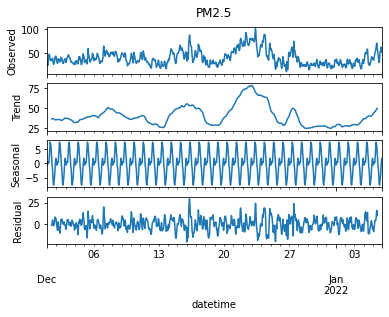

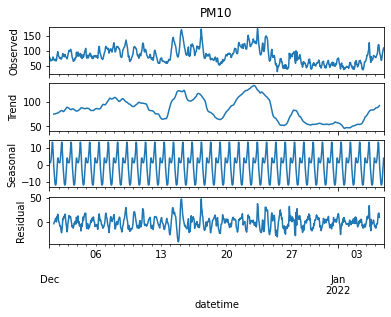

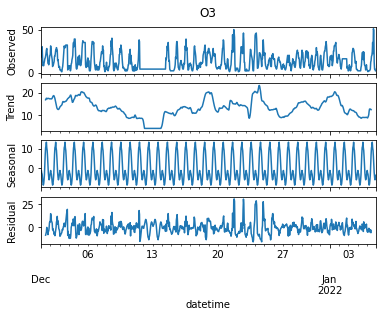

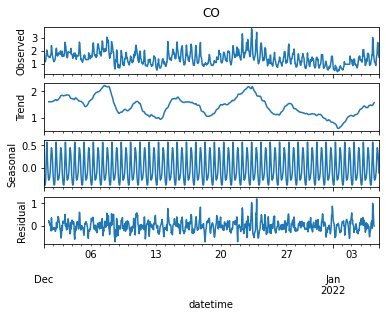

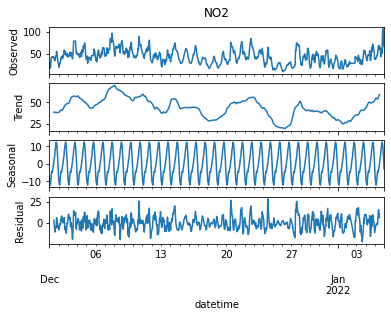

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot all the trend and seasonality of every pollutants

columns = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

for col in columns:
    result = seasonal_decompose(cleaned_pollutants[col], model='add')
    
    fig, axes = plt.subplots(4, 1, sharex=True)
    result.observed.plot(ax=axes[0], legend=False)
    result.trend.plot(ax=axes[1], legend=False)
    result.seasonal.plot(ax=axes[2], legend=False)
    result.resid.plot(ax=axes[3], legend=False)
    plt.title(col,pad=180)
    axes[0].set_ylabel('Observed')
    axes[1].set_ylabel('Trend')
    axes[2].set_ylabel('Seasonal')
    axes[3].set_ylabel('Residual')
    
    plt.show()
    

From the seasonal decomposition, each pollutant's level shift had trend and seasonality.

## Fitting VAR Model
As the quantity of one air substance may influenced the quantity of other air substances, the Vector Autoregression (VAR) model was selected to predict the levels of each air pollutants.

### Test for Stationarity and Data Transformation
Before fitting the VAR model, the data used should not have any trend or seasonality.  To ensure that these values were stationary, Augmented Dickey-Fuller Test was used to test. In case, the data are non-stationary, it should be transformed by differencing until it is stationary.

In [133]:
# ADF test reporting function
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [134]:
cleaned_pollutants.columns

Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2'], dtype='object')

In [135]:
columns = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

for col in columns:
    adf_test(cleaned_pollutants[col], title=col)
    print("\n")

Augmented Dickey-Fuller Test: PM2.5
ADF test statistic       -1.742316
p-value                   0.409452
# lags used              21.000000
# observations          842.000000
critical value (1%)      -3.438140
critical value (5%)      -2.864979
critical value (10%)     -2.568601
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller Test: PM10
ADF test statistic       -2.078250
p-value                   0.253350
# lags used              19.000000
# observations          844.000000
critical value (1%)      -3.438122
critical value (5%)      -2.864971
critical value (10%)     -2.568597
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller Test: O3
ADF test statistic       -3.293522
p-value                   0.015171
# lags used              21.000000
# observations          842.000000
critical value (1%)   

Most pollutants values were non-stationary. Therefore, the data would be transformed by differencing until every pollutants are staionary.

### Differencing : 1 

In [136]:
# transform data by diff function
transformed = cleaned_pollutants.diff().dropna()

# retest the stationarity with Augmented Dickey Fuller method
for col in columns:
    adf_test(transformed[col], title=col)
    print("\n")

Augmented Dickey-Fuller Test: PM2.5
ADF test statistic     -1.208465e+01
p-value                 2.191726e-22
# lags used             2.000000e+01
# observations          8.420000e+02
critical value (1%)    -3.438140e+00
critical value (5%)    -2.864979e+00
critical value (10%)   -2.568601e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: PM10
ADF test statistic     -1.132782e+01
p-value                 1.132012e-20
# lags used             1.800000e+01
# observations          8.440000e+02
critical value (1%)    -3.438122e+00
critical value (5%)    -2.864971e+00
critical value (10%)   -2.568597e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: O3
ADF test statistic     -1.573555e+01
p-value                 1.274089e-28
# lags used             2.100000e+01
# observations          8.410000e+02
crit

## Training data with VAR model
To train the data for prediction, the model VAR was selected as these pollutant indicators may affect each other.

### Train Test Split Data
As this project's objective is to forecast PM2.5 in the next 2 days, the test dataset was the latest 48 consecutive data points (24 hours x 2 days).

In [137]:
test_len = 2*24
train = transformed.iloc[:-test_len]
test = transformed.iloc[-test_len:]

In [138]:
train.shape

(815, 5)

In [139]:
test.shape

(48, 5)

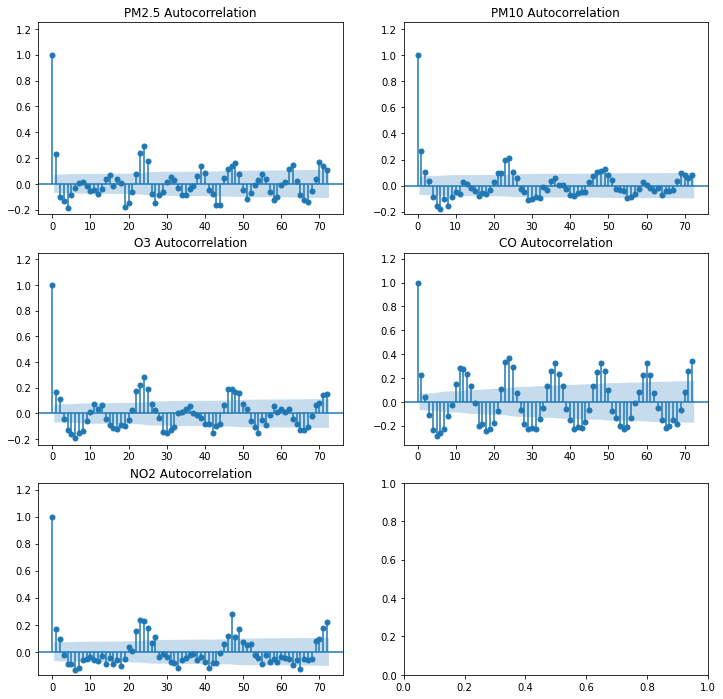

In [140]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lags = 24*3

# create figure and axes
fig, axes = plt.subplots(3,2, figsize=(12,12))

# unpack the axes subplots
axe = axes.ravel()

for i in range(len(columns)):
    axe[i] = plot_acf(train[columns[i]],title = columns[i] + ' Autocorrelation', ax=axe[i], lags=lags, auto_ylims=True)


There were sharp drops in all Autocorrelation plots indicating that there was no AR component for forcasting.

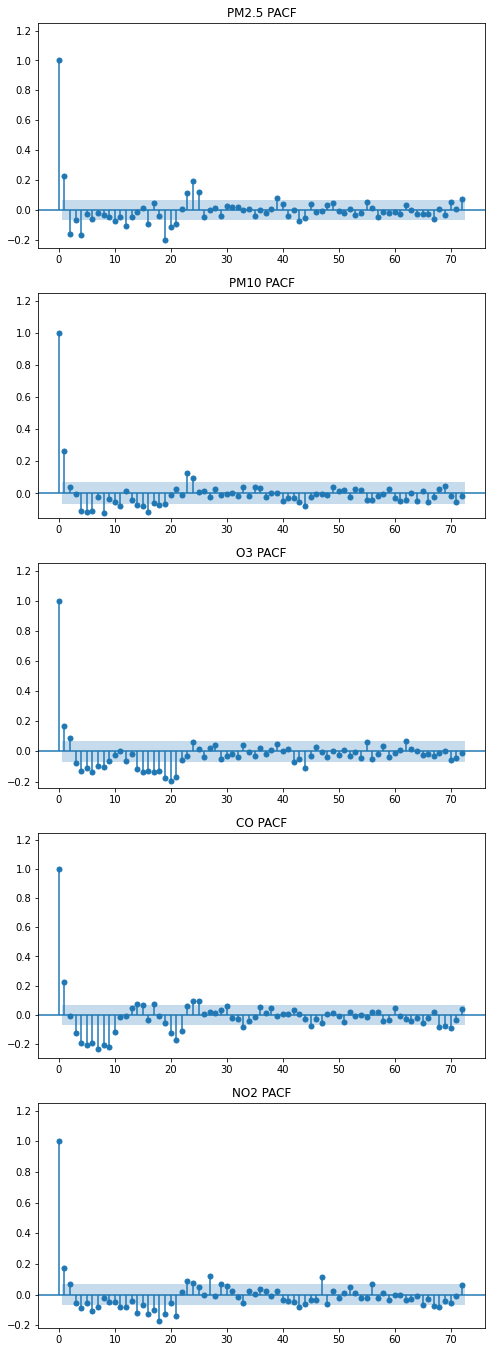

In [141]:
lags = 24*3

# create figure and axes
fig, axes = plt.subplots(5,1, figsize=(8,24))

# unpack the axes subplots
axe = axes.ravel()

for i in range(len(columns)):
    axe[i] = plot_pacf(train[columns[i]],title = columns[i] + ' PACF', ax=axe[i], lags=lags, auto_ylims=True,method = 'ywm')


From partial autocorrelation diagrams after differencing, they showed that the levels of all pollutants had little relationship with their lags. As they were hourly measurement, most pollutants had autocorrelation values at lag 1 only about 0.2.  

### The VAR(p) Model Order Selection

In [142]:
# create a model and find the proper order (p) for the model
var_model = VAR(train)
for i in range(1,16):
    results = var_model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  10.646405834306897
BIC:  10.819696756886843

Order = 2
AIC:  10.558205765256874
BIC:  10.87621340489418

Order = 3
AIC:  10.500726306809243
BIC:  10.963731266431083

Order = 4
AIC:  10.375339963993257
BIC:  10.983623744119173

Order = 5
AIC:  10.31494990424924
BIC:  11.068794906961145

Order = 6
AIC:  10.28387545314004
BIC:  11.183564986074607

Order = 7
AIC:  10.247091470181708
BIC:  11.292909750545318

Order = 8
AIC:  10.231149002869664
BIC:  11.423381161476033

Order = 9
AIC:  10.191605635054158
BIC:  11.530537720384832

Order = 10
AIC:  10.151246601351206
BIC:  11.637165583639074

Order = 11
AIC:  10.14030453588565
BIC:  11.773498311221609

Order = 12
AIC:  10.132068061713326
BIC:  11.912825456176293

Order = 13
AIC:  10.128370521019754
BIC:  12.056981294830166

Order = 14
AIC:  10.13526926181122
BIC:  12.212024113508184

Order = 15
AIC:  10.15425943635857
BIC:  12.379450007000838



According to AIC criterion, the order equal to 13 was selected. However, the AIC statistic penalizes complex models less than the BIC. Thus, the order 1 was selected to fit the VAR(p) model.

In [143]:
var_model.endog_names

['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

In [144]:
result = var_model.fit(1)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Feb, 2022
Time:                     02:20:08
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    10.8197
Nobs:                     814.000    HQIC:                   10.7129
Log likelihood:          -10078.2    FPE:                    42041.3
AIC:                      10.6464    Det(Omega_mle):         40525.5
--------------------------------------------------------------------
Results for equation PM2.5
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.006095         0.170808            0.036           0.972
L1.PM2.5         0.152708         0.036864            4.142           0.000
L1.PM10          0.119450         0.026253            4.550           0.000
L1.O

In [145]:
lag_order = result.k_ar
lag_order

1

## Forecast 

In [146]:
# forecast the pollutants' level 
z = result.forecast(y=train.values[-lag_order:], steps=test_len)
z

array([[-2.04827142e+00, -3.21904160e+00,  2.26229446e-01,
        -2.54968298e-02, -4.61093835e-01],
       [-7.81008547e-01, -1.28602196e+00, -2.06817405e-02,
         7.51498934e-03,  2.52729278e-01],
       [-2.41597603e-01, -3.76550787e-01, -3.48197334e-02,
         6.28967715e-03,  1.88455765e-01],
       [-5.47281136e-02, -9.40381143e-02, -2.65196487e-02,
         2.61479420e-03,  9.23283473e-02],
       [-5.49040876e-03, -2.69836431e-02, -2.12496584e-02,
         7.94331065e-04,  4.61945667e-02],
       [ 3.57916304e-03, -1.71971700e-02, -1.94490142e-02,
         1.72260799e-04,  3.03640767e-02],
       [ 3.92762351e-03, -1.80515500e-02, -1.90468929e-02,
         1.13451783e-05,  2.61396279e-02],
       [ 3.30924917e-03, -1.93523013e-02, -1.90198367e-02,
        -1.65181291e-05,  2.53276265e-02],
       [ 2.96134156e-03, -1.99439611e-02, -1.90485091e-02,
        -1.65152543e-05,  2.52744724e-02],
       [ 2.83787249e-03, -2.01316218e-02, -1.90679657e-02,
        -1.39906531e-05

### Forecast Data Inversion

In [147]:
# check the format of testing data
test.head()

,PM2.5,PM10,O3,CO,NO2
datetime,,,,,
2022-01-04 00:00:00,-2.0,3.0,0.0,0.02,-4.0
2022-01-04 01:00:00,6.0,3.0,-1.0,0.04,-3.0
2022-01-04 02:00:00,2.0,6.0,0.0,-0.07,-5.0
2022-01-04 03:00:00,10.0,9.0,0.0,-0.12,-3.0
2022-01-04 04:00:00,3.0,-1.0,0.0,0.01,0.0


In [148]:
test.tail()

,PM2.5,PM10,O3,CO,NO2
datetime,,,,,
2022-01-05 19:00:00,5.0,11.0,-37.0,0.47,42.0
2022-01-05 20:00:00,1.0,6.0,-8.0,0.51,14.0
2022-01-05 21:00:00,7.0,6.0,0.0,-0.54,-20.0
2022-01-05 22:00:00,-4.0,6.0,-2.0,-0.26,-13.0
2022-01-05 23:00:00,-7.0,-1.0,0.0,-0.34,-8.0


In [149]:
# create a forecast dataframe with the same format as testing data
idx = pd.date_range('2022-01-04 00:00:00', periods=test_len, freq='H')
df_forecast = pd.DataFrame(z, index=idx, columns=['PM2.5_1d', 'PM10_1d', 'O3_1d', 'CO_1d', 'NO2_1d'])
df_forecast.head()

,PM2.5_1d,PM10_1d,O3_1d,CO_1d,NO2_1d
2022-01-04 00:00:00,-2.048271,-3.219042,0.226229,-0.025497,-0.461094
2022-01-04 01:00:00,-0.781009,-1.286022,-0.020682,0.007515,0.252729
2022-01-04 02:00:00,-0.241598,-0.376551,-0.034820,0.006290,0.188456
2022-01-04 03:00:00,-0.054728,-0.094038,-0.026520,0.002615,0.092328
2022-01-04 04:00:00,-0.005490,-0.026984,-0.021250,0.000794,0.046195


## Invert the Transformation

In [150]:
# Add the most recent value from the training side of the original dataset to the forecast cumulative sum
for col in columns:
    df_forecast[col+'_forecast'] = cleaned_pollutants[col].iloc[-test_len-1]-df_forecast[col+'_1d'].cumsum()

In [151]:
df_forecast.head()

,PM2.5_1d,PM10_1d,O3_1d,CO_1d,NO2_1d,PM2.5_forecast,PM10_forecast,O3_forecast,CO_forecast,NO2_forecast
2022-01-04 00:00:00,-2.048271,-3.219042,0.226229,-0.025497,-0.461094,33.048271,67.219042,2.773771,1.275497,50.461094
2022-01-04 01:00:00,-0.781009,-1.286022,-0.020682,0.007515,0.252729,33.829280,68.505064,2.794452,1.267982,50.208365
2022-01-04 02:00:00,-0.241598,-0.376551,-0.034820,0.006290,0.188456,34.070878,68.881614,2.829272,1.261692,50.019909
2022-01-04 03:00:00,-0.054728,-0.094038,-0.026520,0.002615,0.092328,34.125606,68.975652,2.855792,1.259077,49.927580
2022-01-04 04:00:00,-0.005490,-0.026984,-0.021250,0.000794,0.046195,34.131096,69.002636,2.877041,1.258283,49.881386


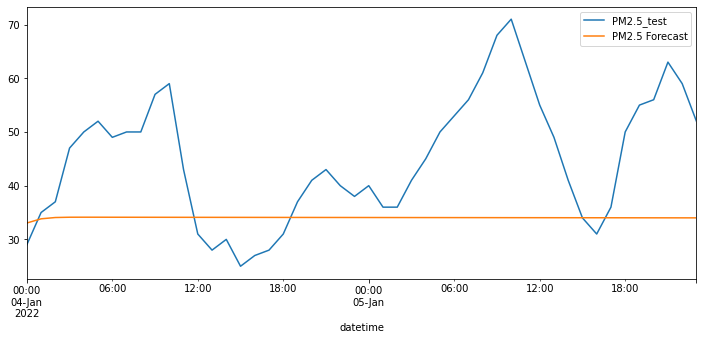

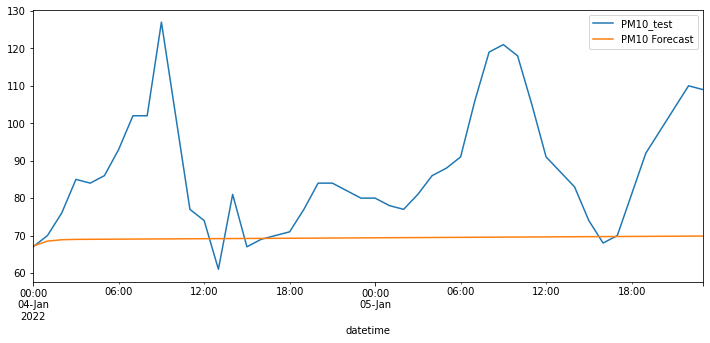

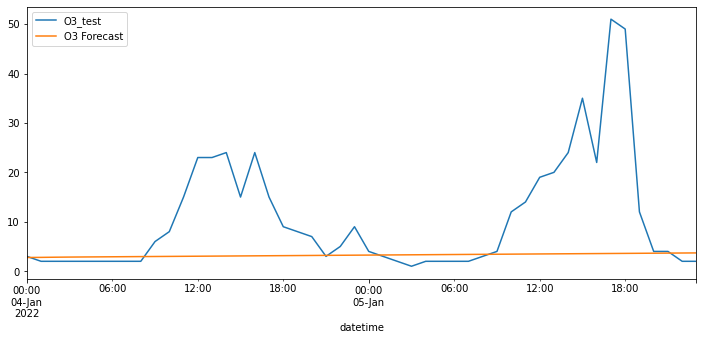

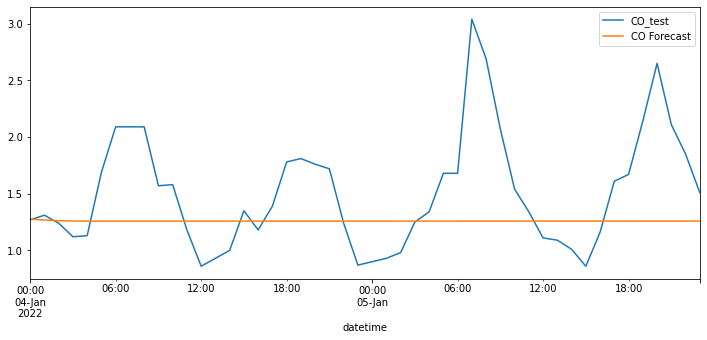

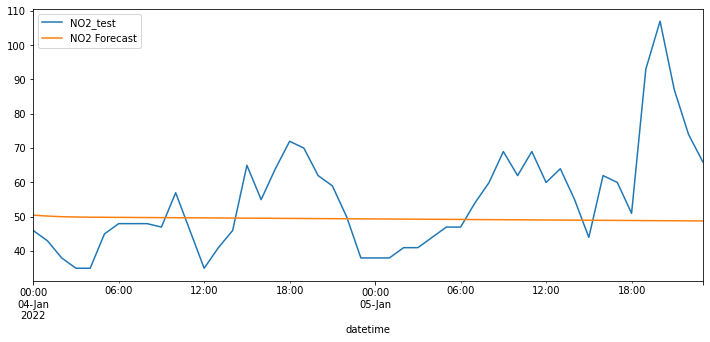

In [152]:
# plot the test data vs prediction
for col in columns:
    plt.figure(figsize=(12,5))
    # cleaned_pollutants[col][:-test_len].plot(legend=True,label=col+'_train')
    cleaned_pollutants[col][-test_len:].plot(figsize=(12,5),legend=True, label=col +'_test');
    df_forecast[col+'_forecast'].plot(legend=True, label= col + " Forecast");

## Evaluating Model
To evaluate model, the root mean square error (rmse) was calculated to check the difference between test dataset and  prediction.

In [153]:
# calculate rmse of each pollutant
for col in columns:
    print("RMSE VAR(1) for " + col + ": " + str(rmse(cleaned_pollutants[col][-test_len:], df_forecast[col+'_forecast'])))


RMSE VAR(1) for PM2.5: 15.956720802504154
RMSE VAR(1) for PM10: 23.808792160272077
RMSE VAR(1) for O3: 13.764077742943456
RMSE VAR(1) for CO: 0.5614984310042487
RMSE VAR(1) for NO2: 16.327497117175266


## Compare Results to Individual AR

In [154]:
from statsmodels.tsa.ar_model import AutoReg,AutoRegResults

### Fitting data with AR model

In [155]:
components =['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

for component in components:
    model = AutoReg(train[component], lags=1).fit()
    start=len(train)
    end=len(train)+len(test)-1
    z = pd.DataFrame(model.predict(start=start, end=end, dynamic=False),columns=[component])
    # Inversion
    z[component+'_forecast'] = cleaned_pollutants[component].iloc[-test_len-1] + z[component].cumsum()
    rmse_var = rmse(cleaned_pollutants[component][-test_len:], df_forecast[component+'_forecast'])
    rmse_ar = rmse(cleaned_pollutants[component][-test_len:], z[component+'_forecast'])
    print('{component}, VAR(1) RMSE: {rmse_var} '.format(component=component, rmse_var=rmse_var))
    print('{component}, AR(1) RMSE: {rmse_ar} '.format(component=component, rmse_ar=rmse_ar))
    print('\n')
    
    

PM2.5, VAR(1) RMSE: 15.956720802504154 
PM2.5, AR(1) RMSE: 19.483096653924058 


PM10, VAR(1) RMSE: 23.808792160272077 
PM10, AR(1) RMSE: 28.19403771127949 


O3, VAR(1) RMSE: 13.764077742943456 
O3, AR(1) RMSE: 14.42593495688002 


CO, VAR(1) RMSE: 0.5614984310042487 
CO, AR(1) RMSE: 0.6122300722670625 


NO2, VAR(1) RMSE: 16.327497117175266 
NO2, AR(1) RMSE: 15.794447024204818 




The result from VAR model can do better for most pollutants level except for NO2 meaning that they had some effects among one another.

In [158]:
# to check descriptive statistics of pollutants in the train dataset 
cleaned_pollutants.iloc[:-test_len].describe()

,PM2.5,PM10,O3,CO,NO2
count,816.000000,816.000000,816.000000,816.000000,816.000000
mean,40.333333,83.504902,13.501225,1.440282,43.379902
std,15.309540,26.809027,10.172500,0.528165,15.761420
min,12.000000,30.000000,1.000000,0.380000,10.000000
25%,29.000000,63.750000,5.000000,1.030000,31.000000
50%,37.000000,81.000000,11.000000,1.380000,42.000000
75%,48.000000,101.000000,20.000000,1.760000,54.000000
max,101.000000,174.000000,50.000000,3.720000,97.000000


Compared the root mean square error with each pollutants' mean, the model predicted very bad. 

# Summary
The PACF plots showed that pollutants changes in Din Daeng District, Bangkok had insignificantly relationship with its lag 1. Each pollutant seemed to have effects on each other as Vector Autoregression model gave less error thant  Autoregression model. However, both VAR and AR models were still not good to predict the value in the next two days (48 hours) as their errors were still high compared to their means.